<div id="ch:advec"></div>

Wave (the chapter [ch:wave](../02_wave)) and diffusion (the chapter [ch:diffu](../03_diffu))
equations are solved reliably by finite difference methods. As soon as
we add a first-order derivative in space, representing *advective*
transport (also known as *convective* transport), the numerics gets
more complicated and intuitively attractive methods no longer work
well. We shall show how and why such methods fail and provide
remedies. The present chapter builds on basic knowledge about finite
difference methods for diffusion and wave equations, including the
analysis by Fourier components, truncation error analysis ([ch:trunc](../B_trunc/trunc.ipynb)), and compact difference notation.

**Remark on terminology.**

It is common to refer to movement of a fluid as convection, while advection
is the transport of some material dissolved or suspended in the fluid.
We shall mostly choose the word advection here, but both terms are
in heavy use, and for mass transport of a substance the PDE has an
advection term, while the similar term for the heat equation is a
convection term.



Much more comprehensive discussion of dispersion analysis for
advection problems can be found in the book by <cite data-cite="8023556/KKSJA3CM">Duran</cite>.
This is a an excellent resource for further studies on the topic of
advection PDEs, with emphasis on gener
alizations to real geophysical
problems. The book by <cite data-cite="8023556/J9FF4ZJM">Fletcher</cite> also has a good
overview of methods for advection and convection problems.

# One-dimensional time-dependent advection equations
<div id="advec:1D"></div>

We consider the pure advection model

<!-- Equation labels as ordinary links -->
<div id="advec:1D:pde1:u"></div>

$$
\begin{equation}
\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} = 0,\quad
 x\in (0,L),\ t\in (0,T],
\label{advec:1D:pde1:u} \tag{1}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="advec:1D:pde1:U0"></div>

$$
\begin{equation} 
u(x,0) = I(x), x\in (0,L),
\label{advec:1D:pde1:U0} \tag{2}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="advec:1D:pde1:I"></div>

$$
\begin{equation} 
u(0,t) = U_0, t\in (0,T].
\label{advec:1D:pde1:I} \tag{3}
\end{equation}
$$

In ([1](#advec:1D:pde1:u)), $v$ is a given parameter, typically reflecting
the transport velocity of a quantity $u$ with a flow.
There is only one boundary condition ([3](#advec:1D:pde1:I)) since
the spatial derivative is only first order in the PDE ([1](#advec:1D:pde1:u)).
The information at $x=0$ and the initial condition get
transported in the positive $x$ direction
if $v>0$ through the domain.

It is easiest to find the solution of ([1](#advec:1D:pde1:u)) if we remove the
boundary condition and consider a process on the
infinite domain $(-\infty, \infty)$. The solution is simply

<!-- Equation labels as ordinary links -->
<div id="advec:1D:pde1:sol"></div>

$$
\begin{equation}
u(x,t) = I(x-vt)\thinspace .
\label{advec:1D:pde1:sol} \tag{4}
\end{equation}
$$

This is also the solution we expect locally in a finite domain before boundary
conditions have reflected or modified the wave.

A particular feature of the solution ([4](#advec:1D:pde1:sol)) is that

<!-- Equation labels as ordinary links -->
<div id="advec:1D:pde1:uprop1"></div>

$$
\begin{equation}
u(x_i, t_{n+1}) = u(x_{i-1}, t_n),
\label{advec:1D:pde1:uprop1} \tag{5}
\end{equation}
$$

if $x_i=i\Delta x$ and $t_n=n\Delta t$ are points in a uniform mesh.
We see this relation from

$$
u(i\Delta x, (n+1)\Delta t) = I(i\Delta x - v(n+1)\Delta t) \nonumber
$$

$$
= I((i-1)\Delta x - vn\Delta t - v\Delta t + \Delta x) \nonumber
$$

$$
= I((i-1)\Delta x - vn\Delta t) \nonumber
$$

$$
= u((i-1)\Delta x, n\Delta t), \nonumber
$$

provided $v = \Delta x/\Delta t$. So, whenever we see a scheme that
collapses to

<!-- Equation labels as ordinary links -->
<div id="advec:1D:pde1:uprop2"></div>

$$
\begin{equation}
u^{n+1}_i = u_{i-1}^n,
\label{advec:1D:pde1:uprop2} \tag{6}
\end{equation}
$$

for the PDE in question, we have in fact a scheme that reproduces the
analytical solution, and many of the schemes to be presented possess
this nice property!

Finally, we add that a discussion of appropriate boundary conditions
for the advection PDE in multiple dimensions is a challenging topic beyond
the scope of this text.

## Simplest scheme: forward in time, centered in space
<div id="advec:1D:FTCS"></div>

### Method

A first attempt to solve a PDE like ([1](#advec:1D:pde1:u)) will normally
be to look for a time-discretization scheme that is explicit so we avoid
solving systems of linear equations. In space, we anticipate that
centered differences are most accurate and therefore best. These
two arguments lead us to a Forward Euler scheme in time and
centered differences in space:

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
[D_t^+ u + vD_{2x} u = 0]^n_i
\label{_auto1} \tag{7}
\end{equation}
$$

Written out, we see that this expression implies that

$$
u^{n+1} = u^n - \frac{1}{2} C (u^n_{i+1}-u_{i-1}^n),
$$

with $C$ as the Courant number

$$
C = \frac{v\Delta t}{\Delta x}\thinspace .
$$

### Implementation

A solver function for our scheme goes as follows.

In [1]:
from devito import *

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


def solver_FECS(I, U0, v, L, dt, C, T, user_action=None):
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = v*dt/C
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    C = v*dt/dx

    u   = np.zeros(Nx+1)
    u_n = np.zeros(Nx+1)

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_n[i] = I(x[i])

    if user_action is not None:
        user_action(u_n, x, t, 0)

    for n in range(0, Nt):
        # Compute u at inner mesh points
        for i in range(1, Nx):
            u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[i-1])

        # Insert boundary condition
        u[0] = U0

        if user_action is not None:
            user_action(u, x, t, n+1)

        # Switch variables before next step
        u_n, u = u, u_n
    print(u)
    print(u_n)

In [35]:
def I(x):
    return np.exp(-0.5*((x-L/10)/sigma)**2)

In [11]:
U0 = 0
v = 1.0
L=1
dt=0.001
C=1
T=1
sigma=0.02

In [12]:
solver_FECS(I, U0, v, L, dt, C, T)

[ 0.00000000e+000  1.13055561e+140 -3.00559361e+140 ... -2.08932903e+006
 -9.13720107e+005  0.00000000e+000]
[ 0.00000000e+000  2.63335241e+140 -7.42239679e+139 ... -3.07699740e+006
 -1.95838462e+006  0.00000000e+000]


In [44]:
Nt = int(round(T/float(dt)))
dx = v*dt/C
Nx = int(round(L/dx))

t = np.linspace(0, Nt*dt, Nt+1)
x = np.linspace(0, L, Nx+1)
# print(x)
dx = float(x[1] - x[0])
# print(dx)
dt = float(t[1] - t[0])
print(dt)
C = v*dt/dx
 
grid = Grid(shape=(Nx), extent=(L))  # or Nx + 1?
t_s=grid.stepping_dim

u = TimeFunction(name='u', grid=grid, space_order=2)

pde = u.dt + v*u.dx
eq = Eq(u.forward, solve(pde, u.forward))
bc = [Eq(u[t_s, 0], 0)]

for i in range(0, Nx):  # or Nx + 1?
    u.data[0, i] = I(x[i])
    u.data[1, i] = I(x[i])

op = Operator([eq] + bc)
op.apply(dt=dt, time_m=1, time_M = Nt)
# print(u.data)
# for i in range(Nt):
#     op.apply(time=100)
#     print("Batch:", i + 1)
#     print(u.data[0])
#     plot_field(u.data[0])
print(u.data)
op.parameters
# print(op.ccode)

Operator `Kernel` run in 0.01 s


0.001
[[ 0. nan nan ...  0.  0.  0.]
 [nan nan nan ...  0.  0.  0.]]


(dt, h_x, u(t, x), time_M, time_m, timers, x_M, x_m)

In [45]:
Nt = int(round(T/float(dt)))
dx = v*dt/C
Nx = int(round(L/dx))

t = np.linspace(0, Nt*dt, Nt+1)
x = np.linspace(0, L, Nx+1)

dx = x[1] - x[0]
# print(dx)
dt = t[1] - t[0]
# print(dt)
dt = float(dt)
C = v*dt/dx

# t = Dimension('t', spacing=Constant('h_t'))
# print(t)
# x = Dimension('x', spacing=Constant('h_t'))

u = TimeFunction(name='u', dimensions=(t, x), shape=(Nt+1, Nx+1), space_order=2)


u.data[:] = U0
eqn = u.dt + v*u.dx
stencil = Eq(u, solve(eqn, u))
op = Operator(stencil)
# op.apply(h_t=dt, t_M=Nt-1)
op()
print(u.data)


Operator `Kernel` run in 0.01 s


0.001
0.001
t
[[nan nan nan ... nan nan  0.]
 [nan nan nan ... nan nan  0.]
 [nan nan nan ... nan nan  0.]
 ...
 [nan nan nan ... nan nan  0.]
 [nan nan nan ... nan nan  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


### Test cases

The typical solution $u$ has the shape of $I$ and is transported at
velocity $v$ to the right (if $v>0$). Let us consider two different
initial conditions, one smooth (Gaussian pulse) and one non-smooth
(half-truncated cosine pulse):

<!-- Equation labels as ordinary links -->
<div id="advec:1D:case_gaussian"></div>

$$
\begin{equation}
u(x,0) = Ae^{-\frac{1}{2}\left(\frac{x-L/10}{\sigma}\right)^2},
\label{advec:1D:case_gaussian} \tag{8}
\end{equation}
$$

<!-- Equation labels as ordinary links -->
<div id="advec:1D:case_cos"></div>

$$
\begin{equation} 
u(x,0) = A\cos\left(\frac{5\pi}{L}\left( x - \frac{L}{10}\right)\right),\quad
x < \frac{L}{5} \hbox{ else } 0\thinspace .
\label{advec:1D:case_cos} \tag{9}
\end{equation}
$$

The parameter $A$ is the maximum value of the initial condition.

Before doing numerical simulations, we scale the PDE
problem and introduce $\bar x = x/L$ and $\bar t= vt/L$,
which gives

$$
\frac{\partial\bar u}{\partial \bar t} +
\frac{\partial\bar u}{\partial\bar x} = 0\thinspace .
$$

The unknown $u$ is scaled by the maximum value of the initial condition:
$\bar u = u/\max |I(x)|$ such that $|\bar u(\bar x, 0)|\in [0,1]$.
The scaled problem is solved by setting $v=1$, $L=1$, and $A=1$.
From now on we drop the bars.

To run our test cases and plot the solution, we make the function

In [43]:
def run_FECS(case):
    """Special function for the FECS case."""
    if case == 'gaussian':
        def I(x):
            return np.exp(-0.5*((x-L/10)/sigma)**2)
    elif case == 'cosinehat':
        def I(x):
            return np.cos(np.pi*5/L*(x - L/10)) if x < L/5 else 0

    L = 1.0
    sigma = 0.02
    legends = []

    def plot(u, x, t, n):
        """Animate and plot every m steps in the same figure."""
        plt.figure(1)
        if n == 0:
            lines = plot(x, u)
        else:
            lines[0].set_ydata(u)
            plt.draw()
            #plt.savefig()
        plt.figure(2)
        m = 40
        if n % m != 0:
            return
        print('t=%g, n=%d, u in [%g, %g] w/%d points' % \
              (t[n], n, u.min(), u.max(), x.size))
        if np.abs(u).max() > 3:  # Instability?
            return
        plt.plot(x, u)
        legends.append('t=%g' % t[n])

    plt.ion()
    U0 = 0
    dt = 0.001
    C = 1
    T = 1
    solver(I=I, U0=U0, v=1.0, L=L, dt=dt, C=C, T=T,
           user_action=plot)
    plt.legend(legends, loc='lower left')
    plt.savefig('tmp.png'); plt.savefig('tmp.pdf')
    plt.axis([0, L, -0.75, 1.1])
    plt.show()

dt=0.01, dx=0.01, Nx=100, C=1
t=0, n=0, u in [0, 1] w/101 points
I: 0.05013256263381491


<ipython-input-49-8810bce8247d>:204: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(0.15)


I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381491
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.05013256263381492
I: 0.050132

<ipython-input-49-8810bce8247d>:264: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(0.5)  # no effect


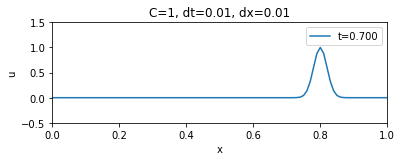

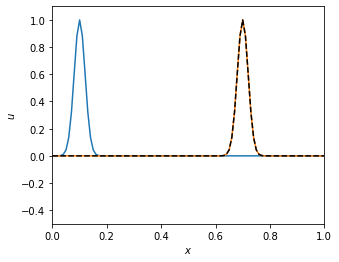

Integral of u: 0.05013256263381492 0.05013254400054906


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# def solver_FECS(I, U0, v, L, dt, C, T, user_action=None):
#     Nt = int(round(T/float(dt)))
#     t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
#     dx = v*dt/C
#     Nx = int(round(L/dx))
#     x = np.linspace(0, L, Nx+1)       # Mesh points in space
#     # Make sure dx and dt are compatible with x and t
#     dx = x[1] - x[0]
#     dt = t[1] - t[0]
#     C = v*dt/dx

#     u   = np.zeros(Nx+1)
#     u_n = np.zeros(Nx+1)

#     # Set initial condition u(x,0) = I(x)
#     for i in range(0, Nx+1):
#         u_n[i] = I(x[i])

#     if user_action is not None:
#         user_action(u_n, x, t, 0)

#     for n in range(0, Nt):
#         # Compute u at inner mesh points
#         for i in range(1, Nx):
#             u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[i-1])

#         # Insert boundary condition
#         u[0] = U0

#         if user_action is not None:
#             user_action(u, x, t, n+1)

#         # Switch variables before next step
#         u_n, u = u, u_n
        

def solver_FECS(I, U0, v, L, dt, C, T, user_action=None):
    


def solver(I, U0, v, L, dt, C, T, user_action=None,
           scheme='FE', periodic_bc=True):
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = v*dt/C
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    C = v*dt/dx
    print('dt=%g, dx=%g, Nx=%d, C=%g' % (dt, dx, Nx, C))

    u   = np.zeros(Nx+1)
    u_n = np.zeros(Nx+1)
    u_nm1 = np.zeros(Nx+1)
    integral = np.zeros(Nt+1)

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_n[i] = I(x[i])

    # Insert boundary condition
    u[0] = U0

    # Compute the integral under the curve
    integral[0] = dx*(0.5*u_n[0] + 0.5*u_n[Nx] + np.sum(u_n[1:-1]))

    if user_action is not None:
        user_action(u_n, x, t, 0)

    for n in range(0, Nt):
        if scheme == 'FE':
            if periodic_bc:
                i = 0
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[Nx])
                u[Nx] = u[0]
                #u[i] = u_n[i] - 0.5*C*(u_n[1] - u_n[Nx])
            for i in range(1, Nx):
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[i-1])
        elif scheme == 'LF':
            if n == 0:
                # Use upwind for first step
                if periodic_bc:
                    i = 0
                    #u[i] = u_n[i] - C*(u_n[i] - u_n[Nx-1])
                    u_n[i] = u_n[Nx]
                for i in range(1, Nx+1):
                    u[i] = u_n[i] - C*(u_n[i] - u_n[i-1])
            else:
                if periodic_bc:
                    i = 0
                    # Must have this,
                    u[i] = u_nm1[i] - C*(u_n[i+1] - u_n[Nx-1])
                    # not this:
                    #u_n[i] = u_n[Nx]
                for i in range(1, Nx):
                    u[i] = u_nm1[i] - C*(u_n[i+1] - u_n[i-1])
                if periodic_bc:
                    u[Nx] = u[0]
        elif scheme == 'UP':
            if periodic_bc:
                u_n[0] = u_n[Nx]
            for i in range(1, Nx+1):
                u[i] = u_n[i] - C*(u_n[i] - u_n[i-1])
        elif scheme == 'LW':
            if periodic_bc:
                i = 0
                # Must have this,
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[Nx-1]) + \
                       0.5*C*(u_n[i+1] - 2*u_n[i] + u_n[Nx-1])
                # not this:
                #u_n[i] = u_n[Nx]
            for i in range(1, Nx):
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[i-1]) + \
                       0.5*C*(u_n[i+1] - 2*u_n[i] + u_n[i-1])
            if periodic_bc:
                u[Nx] = u[0]
        else:
            raise ValueError('scheme="%s" not implemented' % scheme)

        if not periodic_bc:
            # Insert boundary condition
            u[0] = U0

        # Compute the integral under the curve
        integral[n+1] = dx*(0.5*u[0] + 0.5*u[Nx] + np.sum(u[1:-1]))

        if user_action is not None:
            user_action(u, x, t, n+1)

        # Switch variables before next step
        u_nm1, u_n, u = u_n, u, u_nm1
        print('I:', integral[n+1])
    return integral

def run_FECS(case):
    """Special function for the FECS case."""
    if case == 'gaussian':
        def I(x):
            return np.exp(-0.5*((x-L/10)/sigma)**2)
    elif case == 'cosinehat':
        def I(x):
            return np.cos(np.pi*5/L*(x - L/10)) if x < L/5 else 0

    L = 1.0
    sigma = 0.02
    legends = []

    def plot(u, x, t, n):
        """Animate and plot every m steps in the same figure."""
        plt.figure(1)
        if n == 0:
            lines = plot(x, u)
        else:
            lines[0].set_ydata(u)
            plt.draw()
            #plt.savefig()
        plt.figure(2)
        m = 40
        if n % m != 0:
            return
        print('t=%g, n=%d, u in [%g, %g] w/%d points' % \
              (t[n], n, u.min(), u.max(), x.size))
        if np.abs(u).max() > 3:  # Instability?
            return
        plt.plot(x, u)
        legends.append('t=%g' % t[n])

    plt.ion()
    U0 = 0
    dt = 0.001
    C = 1
    T = 1
    solver(I=I, U0=U0, v=1.0, L=L, dt=dt, C=C, T=T,
           user_action=plot)
    plt.legend(legends, loc='lower left')
    plt.savefig('tmp.png'); plt.savefig('tmp.pdf')
    plt.axis([0, L, -0.75, 1.1])
    plt.show()

def run(scheme='UP', case='gaussian', C=1, dt=0.01):
    """General admin routine for explicit and implicit solvers."""

    if case == 'gaussian':
        def I(x):
            return np.exp(-0.5*((x-L/10)/sigma)**2)
    elif case == 'cosinehat':
        def I(x):
            return np.cos(np.pi*5/L*(x - L/10)) \
                   if 0 < x < L/5 else 0

    L = 1.0
    sigma = 0.02
    global lines  # needs to be saved between calls to plot

    def plot(u, x, t, n):
        """Plot t=0 and t=0.6 in the same figure."""
        plt.figure(1)
        global lines
        if n == 0:
            lines = plt.plot(x, u)
            plt.axis([x[0], x[-1], -0.5, 1.5])
            plt.xlabel('x'); plt.ylabel('u')
            plt.axes().set_aspect(0.15)
            plt.savefig('tmp_%04d.png' % n)
            plt.savefig('tmp_%04d.pdf' % n)
        else:
            lines[0].set_ydata(u)
            plt.axis([x[0], x[-1], -0.5, 1.5])
            plt.title('C=%g, dt=%g, dx=%g' %
                      (C, t[1]-t[0], x[1]-x[0]))
            plt.legend(['t=%.3f' % t[n]])
            plt.xlabel('x'); plt.ylabel('u')
            plt.draw()
            plt.savefig('tmp_%04d.png' % n)
        plt.figure(2)
        eps = 1E-14
        if abs(t[n] - 0.6) > eps and abs(t[n] - 0) > eps:
            return
        print('t=%g, n=%d, u in [%g, %g] w/%d points' % \
              (t[n], n, u.min(), u.max(), x.size))
        if np.abs(u).max() > 3:  # Instability?
            return
        plt.plot(x, u)
        plt.draw()
        if n > 0:
            y = [I(x_-v*t[n]) for x_ in x]
            plt.plot(x, y, 'k--')
            if abs(t[n] - 0.6) < eps:
                filename = ('tmp_%s_dt%s_C%s' % \
                            (scheme, t[1]-t[0], C)).replace('.', '')
                np.savez(filename, x=x, u=u, u_e=y)

    plt.ion()
    U0 = 0
    T = 0.7
    v = 1
    # Define video formats and libraries
    codecs = dict(flv='flv', mp4='libx264', webm='libvpx',
                  ogg='libtheora')
    # Remove video files
    import glob, os
    for name in glob.glob('tmp_*.png'):
        os.remove(name)
    for ext in codecs:
        name = 'movie.%s' % ext
        if os.path.isfile(name):
            os.remove(name)

    if scheme == 'CN':
        integral = solver_theta(
            I, v, L, dt, C, T, user_action=plot, FE=False)
    elif scheme == 'BE':
        integral = solver_theta(
            I, v, L, dt, C, T, theta=1, user_action=plot)
    else:
        integral = solver(
            I=I, U0=U0, v=v, L=L, dt=dt, C=C, T=T,
            scheme=scheme, user_action=plot)
    # Finish figure(2)
    plt.figure(2)
    plt.axis([0, L, -0.5, 1.1])
    plt.xlabel('$x$');  plt.ylabel('$u$')
    plt.axes().set_aspect(0.5)  # no effect
    plt.savefig('tmp1.png'); plt.savefig('tmp1.pdf')
    plt.show()
    # Make videos from figure(1) animation files
    for codec in codecs:
        cmd = 'ffmpeg -i tmp_%%04d.png -r 25 -vcodec %s movie.%s' % \
              (codecs[codec], codec)
        os.system(cmd)
    print('Integral of u:', integral.max(), integral.min())

def solver_theta(I, v, L, dt, C, T, theta=0.5, user_action=None, FE=False):
    """
    Full solver for the model problem using the theta-rule
    difference approximation in time (no restriction on F,
    i.e., the time step when theta >= 0.5).
    Vectorized implementation and sparse (tridiagonal)
    coefficient matrix.
    """
    import time;  t0 = time.clock()  # for measuring the CPU time
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = v*dt/C
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    C = v*dt/dx
    print('dt=%g, dx=%g, Nx=%d, C=%g' % (dt, dx, Nx, C))

    u   = np.zeros(Nx+1)
    u_n = np.zeros(Nx+1)
    u_nm1 = np.zeros(Nx+1)
    integral = np.zeros(Nt+1)

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_n[i] = I(x[i])

    # Compute the integral under the curve
    integral[0] = dx*(0.5*u_n[0] + 0.5*u_n[Nx] + np.sum(u_n[1:-1]))

    if user_action is not None:
        user_action(u_n, x, t, 0)

    # Representation of sparse matrix and right-hand side
    diagonal = np.zeros(Nx+1)
    lower    = np.zeros(Nx)
    upper    = np.zeros(Nx)
    b        = np.zeros(Nx+1)

    # Precompute sparse matrix (scipy format)
    diagonal[:] = 1
    lower[:] = -0.5*theta*C
    upper[:] =  0.5*theta*C
    if FE:
        diagonal[:] += 4./6
        lower[:] += 1./6
        upper[:] += 1./6
    # Insert boundary conditions
    upper[0] = 0
    lower[-1] = 0

    diags = [0, -1, 1]
    import scipy.sparse
    import scipy.sparse.linalg
    A = scipy.sparse.diags(
        diagonals=[diagonal, lower, upper],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    #print A.todense()

    # Time loop
    for n in range(0, Nt):
        b[1:-1] = u_n[1:-1] + 0.5*(1-theta)*C*(u_n[:-2] - u_n[2:])
        if FE:
            b[1:-1] += 1./6*u_n[:-2] + 1./6*u_n[:-2] + 4./6*u_n[1:-1]
        b[0] = u_n[Nx]; b[-1] = u_n[0]  # boundary conditions
        b[0] = 0; b[-1] = 0  # boundary conditions
        u[:] = scipy.sparse.linalg.spsolve(A, b)

        if user_action is not None:
            user_action(u, x, t, n+1)

        # Compute the integral under the curve
        integral[n+1] = dx*(0.5*u[0] + 0.5*u[Nx] + np.sum(u[1:-1]))

        # Update u_n before next step
        u_n, u = u, u_n

    t1 = time.clock()
    return integral


run(scheme='LW', case='gaussian', C=1, dt=0.01)


### Bug?

Running either of the test cases, the plot becomes a mess, and
the printout of $u$ values in the `plot` function reveals that
$u$ grows very quickly. We may reduce $\Delta t$ and make it
very small, yet the solution just grows.
Such behavior points to a bug in the code.
However, choosing a coarse mesh and performing one time step by
hand calculations produces the same numbers as the code, so
the implementation seems to be correct.
The hypothesis is therefore that the solution is unstable.

## Analysis of the scheme
<div id="advec:1D:FTCS:anal"></div>

It is easy to show that a typical Fourier component

$$
u(x,t)= B\sin (k(x-ct))
$$

is a solution of our PDE for any spatial wave length $\lambda = 2\pi /k$
and any amplitude $B$. (Since the PDE to be investigated by this method
is homogeneous and linear, $B$ will always cancel out, so we tend to skip
this amplitude, but keep it here in the beginning for completeness.)

A general solution may be viewed as a collection of long and
short waves with different amplitudes. Algebraically, the work
simplifies if we introduce the complex Fourier component

$$
u(x,t)=A_\text{e} e^{ikx},
$$

with

$$
A_\text{e}=Be^{-ikv\Delta t} = Be^{-iCk\Delta x}\thinspace .
$$

Note that $|A_\text{e}| \leq 1$.

It turns out that many schemes also allow a Fourier wave component as
solution, and we can use the numerically computed values of $A_\text{e}$
(denoted $A$) to learn about the
quality of the scheme. Hence, to analyze the difference scheme we have just
implemented, we look at how it treats the Fourier component

$$
u_q^n = A^n e^{ikq\Delta x}\thinspace .
$$

Inserting the numerical component in the scheme,

$$
[D_t^+ A e^{ikq\Delta x} + v D_{2x}A e^{ikq\Delta x} = 0]^n_q,
$$

and making use of ([form:exp:fd1c:center](../A_formulas/formulas.ipynb#form:exp:fd1c:center))
results in

$$
[e^{ikq\Delta x} (\frac{A-1}{\Delta t} + v\frac{1}{\Delta x}i\sin (k\Delta x)) = 0]^n_q,
$$

which implies

$$
A = 1 - iC\sin(k\Delta x)\thinspace .
$$

The numerical solution features the formula $A^n$. To find out whether
$A^n$ means growth in time, we rewrite $A$ in polar form: $A=A_re^{i\phi}$,
for real numbers $A_r$ and $\phi$,
since we then have $A^n = A_r^ne^{i\phi n}$. The magnitude of $A^n$ is
$A_r^n$. In our case, $A_r = (1 + C^2\sin^2(kx))^{1/2} > 1$, so
$A_r^n$ will increase in time, whereas the
exact solution will not. Regardless of $\Delta t$, we get unstable
numerical solutions.

## Leapfrog in time, centered differences in space
<div id="advec:1D:leapfrog"></div>

### Method

Another explicit scheme is to do a "leapfrog" jump over $2\Delta t$ in
time and combine it with central differences in space:

$$
[D_{2t} u + vD_{2x} u = 0]_i^n,
$$

which results in the updating formula

$$
u^{n+1}_i = u^{n-1}_i - C(u_{i+1}^n-u_{i-1}^n)\thinspace .
$$

A special scheme is needed to compute $u^1$, but we leave that problem for
now. Anyway, this special scheme can be found in 
[`advec1D.py`](/edit/04_advec/src-advec/advec1D.py).

### Implementation

We now need to work with three time levels and must modify our solver a bit:

In [3]:
Nt = int(round(T/float(dt)))
t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
...
u   = np.zeros(Nx+1)
u_1 = np.zeros(Nx+1)
u_2 = np.zeros(Nx+1)
...
for n in range(0, Nt):
    if scheme == 'FE':
        for i in range(1, Nx):
            u[i] = u_1[i] - 0.5*C*(u_1[i+1] - u_1[i-1])
    elif scheme == 'LF':
        if n == 0:
            # Use some scheme for the first step
            for i in range(1, Nx):
                ...
        else:
            for i in range(1, Nx+1):
                u[i] = u_2[i] - C*(u_1[i] - u_1[i-1])

    # Switch variables before next step
    u_2, u_1, u = u_1, u, u_2

### Running a test case

Let us try a coarse mesh such that the smooth Gaussian initial condition
is represented by 1 at mesh node 1 and 0 at all other nodes. This
triangular initial condition should then be advected to the right.
Choosing scaled variables as $\Delta t=0.1$, $T=1$, and $C=1$ gives
the plot in [Figure](#advec:1D:case_gaussian:fig:LFCS), which
is in fact identical to the exact solution (!).

<!-- dom:FIGURE: [fig-advec/solver_FE_Upw.png, width=500 frac=0.8] Exact solution obtained by Leapfrog scheme with $\Delta t = 0.1$ and $C=1$. <div id="advec:1D:case_gaussian:fig:LFCS"></div> -->
<!-- begin figure -->
<div id="advec:1D:case_gaussian:fig:LFCS"></div>

<p>Exact solution obtained by Leapfrog scheme with $\Delta t = 0.1$ and $C=1$.</p>
<img src="fig-advec/solver_FE_Upw.png" width=500>

<!-- end figure -->


### Running more test cases

We can run two types of initial conditions for $C=0.8$: one very
smooth with a Gaussian function ([Figure](#advec:1D:LF:fig1:C08)) and
one with a discontinuity in the first derivative ([Figure](#advec:1D:LF:fig2:C08)).  Unless we have a very fine mesh, as in
the left plots in the figures, we get small ripples behind the main
wave, and this main wave has the amplitude reduced.

<!-- dom:FIGURE: [fig-advec/gaussian_LF_C08.png, width=800 frac=1] Advection of a Gaussian function with a leapfrog scheme and $C=0.8$, $\Delta t = 0.001$ (left) and $\Delta t=0.01$ (right). <div id="advec:1D:LF:fig1:C08"></div> -->
<!-- begin figure -->
<div id="advec:1D:LF:fig1:C08"></div>

<p>Advection of a Gaussian function with a leapfrog scheme and $C=0.8$, $\Delta t = 0.001$ (left) and $\Delta t=0.01$ (right).</p>
<img src="fig-advec/gaussian_LF_C08.png" width=800>

<!-- end figure -->


Advection of the Gaussian function with a leapfrog scheme, using $C=0.8$ and $\Delta t = 0.01$ can be seen in a [movie file](/view/04_advec/mov-advec/gaussian/LF/C08_dt01.ogg). Alternatively, with $\Delta t = 0.001$, we get this [movie file](/view/04_advec/mov-advec/gaussian/LF/C08_dt001.ogg).

<!-- dom:FIGURE: [fig-advec/cosinehat_LF_C08.png, width=800 frac=1] Advection of frac{1}{2} a cosine function with a leapfrog scheme and $C=0.8$, $\Delta t = 0.001$ (left) and $\Delta t=0.01$ (right). <div id="advec:1D:LF:fig2:C08"></div> -->
<!-- begin figure -->
<div id="advec:1D:LF:fig2:C08"></div>

<p>Advection of half a cosine function with a leapfrog scheme and $C=0.8$, $\Delta t = 0.001$ (left) and $\Delta t=0.01$ (right).</p>
<img src="fig-advec/cosinehat_LF_C08.png" width=800>

<!-- end figure -->


Advection of the cosine hat function with a leapfrog scheme, using $C=0.8$ and $\Delta t = 0.01$ can be seen in a [movie file](/view/04_advec/mov-advec/cosinehat/LF/C08_dt01.ogg). Alternatively, with $\Delta t = 0.001$, we get this [movie file](/view/04_advec/mov-advec/cosinehat/LF/C08_dt001.ogg).


### Analysis

We can perform a Fourier analysis again. Inserting the numerical
Fourier component in the Leapfrog scheme, we get

$$
A^2 - i2C\sin(k\Delta x) A - 1 = 0,
$$

and

$$
A = -iC\sin(k\Delta x) \pm \sqrt{1-C^2\sin^2(k\Delta x)}\thinspace .
$$

Rewriting to polar form, $A=A_re^{i\phi}$, we see that $A_r=1$, so the
numerical component is neither increasing nor decreasing in time, which is
exactly what we want. However, for $C>1$, the square root can become
complex valued, so stability is obtained only as long as $C\leq 1$.

**Stability.**

For all the working schemes to be presented in this chapter, we
get the stability condition $C\leq 1$:

$$
\Delta t \leq \frac{\Delta x}{v}\thinspace .
$$

This is called the CFL condition and applies almost always to successful
schemes for advection problems. Of course, one can use Crank-Nicolson or
Backward Euler schemes for increased and even unconditional
stability (no $\Delta t$ restrictions), but these have other
less desired damping problems.



We introduce $p=k\Delta x$. The amplification factor now reads

$$
A = -iC\sin p \pm \sqrt{1-C^2\sin^2 p},
$$

and is to be compared to the exact amplification factor

$$
A_\text{e} = e^{-ikv\Delta t} = e^{-ikC\Delta x} = e^{-iCp}\thinspace .
$$

the section [Analysis of dispersion relations](#advec:1D:disprel) compares numerical amplification factors
of many schemes with the exact expression.


## Upwind differences in space
<div id="advec:1D:FTUP"></div>

Since the PDE reflects transport of information along with a flow in
positive $x$ direction, when $v>0$, it could be natural to go (what is called)
upstream and not
downstream in the spatial derivative to collect information about the
change of the function. That is, we approximate

$$
\frac{\partial u}{\partial x}(x_i,t_n)\approx [D^-_x u]^n_i = \frac{u^n_{i} - u^n_{i-1}}{\Delta x}\thinspace .
$$

This is called an *upwind difference* (the corresponding difference in the
time direction would be called a backward difference, and we could use that
name in space too, but *upwind* is the common name for a difference against
the flow in advection problems). This spatial approximation does magic
compared to
the scheme we had with Forward Euler in time and centered difference in space.
With an upwind difference,

<!-- Equation labels as ordinary links -->
<div id="advec:1D:upwind"></div>

$$
\begin{equation} [D^+_t u + vD^-_x u = 0]^n_i,
\label{advec:1D:upwind} \tag{10}
\end{equation}
$$

written out as

$$
u^{n+1}_i = u^n_i - C(u^{n}_{i}-u^{n}_{i-1}),
$$

gives a generally popular and robust scheme that is stable if $C\leq 1$.
As with the Leapfrog scheme, it becomes exact if $C=1$, exactly as shown in
[Figure](#advec:1D:case_gaussian:fig:LFCS). This is easy to see since
$C=1$ gives the property ([6](#advec:1D:pde1:uprop2)).
However, any $C<1$ gives a significant reduction in the amplitude of the
solution, which is a purely numerical effect, see Figures
[advec:1D:UP:fig1:C08](#advec:1D:UP:fig1:C08) and [advec:1D:UP:fig2:C08](#advec:1D:UP:fig2:C08).
Experiments show, however, that
reducing $\Delta t$ or $\Delta x$, while keeping $C$ reduces the
error.

<!-- dom:FIGURE: [fig-advec/gaussian_UP_C08.png, width=800 frac=1] Advection of a Gaussian function with a forward in time, upwind in space scheme and $C=0.8$, $\Delta t = 0.01$ (left) and $\Delta t=0.001$ (right). <div id="advec:1D:UP:fig1:C08"></div> -->
<!-- begin figure -->
<div id="advec:1D:UP:fig1:C08"></div>

<p>Advection of a Gaussian function with a forward in time, upwind in space scheme and $C=0.8$, $\Delta t = 0.01$ (left) and $\Delta t=0.001$ (right).</p>
<img src="fig-advec/gaussian_UP_C08.png" width=800>

<!-- end figure -->


Advection of the Gaussian function with a forward in time, upwind in space scheme, using $C=0.8$ and $\Delta t = 0.01$ can be seen in a [movie file](/view/04_advec/mov-advec/gaussian/UP/C08_dt001/movie.ogg). Alternatively, with $\Delta t = 0.005$, we get this [movie file](/view/04_advec/mov-advec/gaussian/UP/C08_dt0005/movie.ogg).

<!-- dom:FIGURE: [fig-advec/cosinehat_UP_08.png, width=800 frac=1] Advection of half a cosine function with a forward in time, upwind in space scheme and $C=0.8$, $\Delta t = 0.001$ (left) and $\Delta t=0.01$ (right). <div id="advec:1D:UP:fig2:C08"></div> -->
<!-- begin figure -->
<div id="advec:1D:UP:fig2:C08"></div>

<p>Advection of half a cosine function with a forward in time, upwind in space scheme and $C=0.8$, $\Delta t = 0.001$ (left) and $\Delta t=0.01$ (right).</p>
<img src="fig-advec/cosinehat_UP_08.png" width=800>

<!-- end figure -->


Advection of the cosine hat function with a forward in time, upwind in space scheme, using $C=0.8$ and $\Delta t = 0.01$ can be seen in a [movie file](/view/04_advec/mov-advec/cosinehat/UP/C08_dt01.ogg). Alternatively, with $\Delta t = 0.001$, we get this [movie file](/view/04_advec/mov-advec/cosinehat/UP/C08_dt001.ogg).

The amplification factor can be computed using the
formula ([form:exp:fd1:bw](/notebooks/A_formulas/formulas.ipynb#form:exp:fd1:bw)),

$$
\frac{A - 1}{\Delta t} + \frac{v}{\Delta x}(1 - e^{-ik\Delta x}) = 0,
$$

which means

$$
A = 1 - C(1 - \cos(p) - i\sin(p))\thinspace .
$$

For $C<1$ there is, unfortunately,
non-physical damping of discrete Fourier components, giving rise to reduced
amplitude of $u^n_i$ as in Figures [advec:1D:UP:fig1:C08](#advec:1D:UP:fig1:C08)
and [advec:1D:UP:fig2:C08](#advec:1D:UP:fig2:C08). The damping seen
in these figures is quite severe. Stability requires $C\leq 1$.

**Interpretation of upwind difference as artificial diffusion.**

One can interpret the upwind difference as extra, artificial diffusion
in the equation. Solving

$$
\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x}
= \nu\frac{\partial^2 u}{\partial x^2},
$$

by a forward difference in time and centered differences in space,

$$
D^+_t u + vD_{2x} u = \nu D_xD_x u]^n_i,
$$

actually gives the upwind scheme ([10](#advec:1D:upwind)) if
$\nu = v\Delta x/2$. That is, solving the PDE $u_t + vu_x=0$
by centered differences in space and forward difference in time is
unsuccessful, but by adding some artificial diffusion $\nu u_{xx}$,
the method becomes stable:

$$
\frac{\partial u}{\partial t} + v
\frac{\partial u}{\partial x} = \left(\alpha + \frac{v\Delta x}{2}\right)
\frac{\partial^2 u}{\partial x^2}\thinspace .
$$

## Periodic boundary conditions
<div id="advec:1D:periodic_BC"></div>

So far, we have given the value on the left boundary, $u_0^n$, and used
the scheme to propagate the solution signal through the domain.
Often, we want to follow such signals for long time series, and periodic
boundary conditions are then relevant since they enable a signal that
leaves the right boundary to immediately enter the left boundary and propagate
through the domain again.

The periodic boundary condition is

$$
u(0,t) = u(L,t),\quad u_0^n = u_{N_x}^n\thinspace .
$$

mathcal{I}_t means that we in the first equation, involving $u_0^n$, insert $u_{N_x}^n$,
and that we in the last equation, involving $u^{n+1}_{N_x}$ insert $u^{n+1}_0$.
Normally, we can do this in the simple way that `u_1[0]` is updated as
`u_1[Nx]` at the beginning of a new time level.

In some schemes we may need $u^{n}_{N_x+1}$ and $u^{n}_{-1}$. Periodicity
then means that these values are equal to $u^n_1$ and $u^n_{N_x-1}$,
respectively. For the upwind scheme, it is sufficient to set
`u_1[0]=u_1[Nx]` at a new time level before computing `u[1]`. This ensures
that `u[1]` becomes right and at the next time level `u[0]` at the current
time level is correctly updated.
For the Leapfrog scheme we must update `u[0]` and `u[Nx]` using the scheme:

In [4]:
if periodic_bc:
    i = 0
    u[i] = u_2[i] - C*(u_1[i+1] - u_1[Nx-1])
for i in range(1, Nx):
    u[i] = u_2[i] - C*(u_1[i+1] - u_1[i-1])
if periodic_bc:
    u[Nx] = u[0]

## Implementation

### Test condition

Analytically, we can show that the integral in space under the $u(x,t)$ curve
is constant:

$$
\begin{align*}
\int_0^L \left(\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x}
\right) dx &= 0\\
\frac{\partial }{\partial t} \int_0^L udx &=
- \int_0^L v\frac{\partial u}{\partial x}dx\\
\frac{\partial u}{\partial t} \int_0^L udx &=
[v u]_0^L =0
\end{align*}
$$

as long as $u(0)=u(L)=0$. We can therefore use the property

$$
\int_0^L u(x,t)dx = \hbox{const}
$$

as a partial verification during the simulation. Now, any numerical method
with $C\neq 1$ will deviate from the constant, expected value, so
the integral is a measure of the error in the scheme. The integral can
be computed by the Trapezoidal integration rule

In [5]:
dx*(0.5*u[0] + 0.5*u[Nx] + np.sum(u[1:-1]))

if `u` is an array holding the solution.

### The code

An appropriate `solver` function for multiple schemes may go as shown
below.

In [6]:
def solver(I, U0, v, L, dt, C, T, user_action=None,
           scheme='FE', periodic_bc=True):

    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = v*dt/C
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    C = v*dt/dx
    print 'dt=%g, dx=%g, Nx=%d, C=%g' % (dt, dx, Nx, C)

    u   = np.zeros(Nx+1)
    u_n = np.zeros(Nx+1)
    u_nm1 = np.zeros(Nx+1)
    integral = np.zeros(Nt+1)

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_n[i] = I(x[i])

    # Insert boundary condition
    u[0] = U0

    # Compute the integral under the curve
    integral[0] = dx*(0.5*u_n[0] + 0.5*u_n[Nx] + np.sum(u_n[1:-1]))

    if user_action is not None:
        user_action(u_n, x, t, 0)

    for n in range(0, Nt):
        if scheme == 'FE':
            if periodic_bc:
                i = 0
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[Nx])
                u[Nx] = u[0]
            for i in range(1, Nx):
                u[i] = u_n[i] - 0.5*C*(u_n[i+1] - u_n[i-1])
        elif scheme == 'LF':
            if n == 0:
                # Use upwind for first step
                if periodic_bc:
                    i = 0
                    u_n[i] = u_n[Nx]
                for i in range(1, Nx+1):
                    u[i] = u_n[i] - C*(u_n[i] - u_n[i-1])
            else:
                if periodic_bc:
                    i = 0
                    u[i] = u_nm1[i] - C*(u_n[i+1] - u_n[Nx-1])
                for i in range(1, Nx):
                    u[i] = u_nm1[i] - C*(u_n[i+1] - u_n[i-1])
                if periodic_bc:
                    u[Nx] = u[0]
        elif scheme == 'UP':
            if periodic_bc:
                u_n[0] = u_n[Nx]
            for i in range(1, Nx+1):
                u[i] = u_n[i] - C*(u_n[i] - u_n[i-1])
        else:
            raise ValueError('scheme="%s" not implemented' % scheme)

        if not periodic_bc:
            # Insert boundary condition
            u[0] = U0

        # Compute the integral under the curve
        integral[n+1] = dx*(0.5*u[0] + 0.5*u[Nx] + np.sum(u[1:-1]))

        if user_action is not None:
            user_action(u, x, t, n+1)

        # Switch variables before next step
        u_nm1, u_n, u = u_n, u, u_nm1
    return integral

### Solving a specific problem

We need to call up the `solver` function in some kind of administering
problem solving function that can solve specific problems and make
appropriate visualization. The function below makes both static plots,
screen animation, and hard copy videos in various formats.

In [7]:
def run(scheme='UP', case='gaussian', C=1, dt=0.01):
    """General admin routine for explicit and implicit solvers."""

    if case == 'gaussian':
        def I(x):
            return np.exp(-0.5*((x-L/10)/sigma)**2)
    elif case == 'cosinehat':
        def I(x):
            return np.cos(np.pi*5/L*(x - L/10)) if x < L/5 else 0

    L = 1.0
    sigma = 0.02
    global lines  # needs to be saved between calls to plot

    def plot(u, x, t, n):
        """Plot t=0 and t=0.6 in the same figure."""
        plt.figure(1)
        global lines
        if n == 0:
            lines = plt.plot(x, u)
            plt.axis([x[0], x[-1], -0.5, 1.5])
            plt.xlabel('x'); plt.ylabel('u')
            plt.axes().set_aspect(0.15)
            plt.savefig('tmp_%04d.png' % n)
            plt.savefig('tmp_%04d.pdf' % n)
        else:
            lines[0].set_ydata(u)
            plt.axis([x[0], x[-1], -0.5, 1.5])
            plt.title('C=%g, dt=%g, dx=%g' %
                      (C, t[1]-t[0], x[1]-x[0]))
            plt.legend(['t=%.3f' % t[n]])
            plt.xlabel('x'); plt.ylabel('u')
            plt.draw()
            plt.savefig('tmp_%04d.png' % n)
        plt.figure(2)
        eps = 1E-14
        if abs(t[n] - 0.6) > eps and abs(t[n] - 0) > eps:
            return
        print 't=%g, n=%d, u in [%g, %g] w/%d points' % \
              (t[n], n, u.min(), u.max(), x.size)
        if np.abs(u).max() > 3:  # Instability?
            return
        plt.plot(x, u)
        plt.draw()
        if n > 0:
            y = [I(x_-v*t[n]) for x_ in x]
            plt.plot(x, y, 'k--')
            if abs(t[n] - 0.6) < eps:
                filename = ('tmp_%s_dt%s_C%s' % \
                            (scheme, t[1]-t[0], C)).replace('.', '')
                np.savez(filename, x=x, u=u, u_e=y)

    plt.ion()
    U0 = 0
    T = 0.7
    v = 1
    # Define video formats and libraries
    codecs = dict(flv='flv', mp4='libx264', webm='libvpx',
                  ogg='libtheora')
    # Remove video files
    import glob, os
    for name in glob.glob('tmp_*.png'):
        os.remove(name)
    for ext in codecs:
        name = 'movie.%s' % ext
        if os.path.isfile(name):
            os.remove(name)

   integral = solver(
       I=I, U0=U0, v=v, L=L, dt=dt, C=C, T=T,
       scheme=scheme, user_action=plot)
    # Finish up figure(2)
    plt.figure(2)
    plt.axis([0, L, -0.5, 1.1])
    plt.xlabel('$x$');  plt.ylabel('$u$')
    plt.savefig('tmp1.png'); plt.savefig('tmp1.pdf')
    plt.show()
    # Make videos from figure(1) animation files
    for codec in codecs:
        cmd = 'ffmpeg -i tmp_%%04d.png -r 25 -vcodec %s movie.%s' % \
              (codecs[codec], codec)
        os.system(cmd)
    print 'Integral of u:', integral.max(), integral.min()

The complete code is found in the file
[`advec1D.py`](/edit/04_advec/src-advec/advec1D.py).

## A Crank-Nicolson discretization in time and centered differences in space
<div id="advec:1D:CN"></div>


Another obvious candidate for time discretization is the Crank-Nicolson
method combined with centered differences in space:

$$
[D_t u]^n_i + v\frac{1}{2}([D_{2x} u]^{n+1}_i + [D_{2x} u]^{n}_i) = 0\thinspace .
$$

It can be nice to include the Backward Euler scheme too, via the
$\theta$-rule,

$$
[D_t u]^n_i + v\theta [D_{2x} u]^{n+1}_i + v(1-\theta)[D_{2x} u]^{n}_i = 0\thinspace .
$$

When $\theta$ is different from zero, this gives rise to an *implicit* scheme,

$$
u^{n+1}_i + \frac{\theta}{2} C (u^{n+1}_{i+1} - u^{n+1}_{i-1})
= u^n_i - \frac{1-\theta}{2} C (u^{n}_{i+1} - u^{n}_{i-1})
$$

for $i=1,\ldots,N_x-1$. At the boundaries we set $u=0$ and simulate just to
the point of time when the signal hits the boundary (and gets reflected).

$$
u^{n+1}_0 = u^{n+1}_{N_x} = 0\thinspace .
$$

The elements on the diagonal in the matrix become:

$$
A_{i,i} = 1,\quad i=0,\ldots,N_x\thinspace .
$$

On the subdiagonal and superdiagonal we have

$$
A_{i-1,i} = -\frac{\theta}{2} C,\quad A_{i+1,i} = \frac{\theta}{2} C,\quad i=1,\ldots,N_x-1,
$$

with $A_{0,1}=0$ and $A_{N_x-1,N_x}=0$ due to the known boundary conditions.
And finally, the right-hand side becomes

$$
\begin{align*}
b_0 &= u^n_{N_x}\\
b_i &= u^n_i - \frac{1-\theta}{2} C (u^{n}_{i+1} - u^{n}_{i-1}),\quad i=1,\ldots,N_x-1\\
b_{N_x} &= u^n_0
\end{align*}
$$

The dispersion relation follows from inserting $u^n_q = A^ne^{ikx}$
and using the formula ([form:exp:fd1c:center](/notebooks/A_formulas/formulas.ipynb#form:exp:fd1c:center)) for the spatial
differences:

$$
A = \frac{1 - (1-\theta) i C\sin p}{1 + \theta i C\sin p}\thinspace .
$$

<!-- dom:FIGURE: [fig-advec/gaussian_CN_C08.png, width=800 frac=1] Crank-Nicolson in time, centered in space, Gaussian profile, $C=0.8$, $\Delta t = 0.01$ (left) and $\Delta t=0.005$ (right). <div id="advec:1D:CN:fig:C08"></div> -->
<!-- begin figure -->
<div id="advec:1D:CN:fig:C08"></div>

<p>Crank-Nicolson in time, centered in space, Gaussian profile, $C=0.8$, $\Delta t = 0.01$ (left) and $\Delta t=0.005$ (right).</p>
<img src="fig-advec/gaussian_CN_C08.png" width=800>

<!-- end figure -->


<!-- dom:FIGURE: [fig-advec/cosinehat_BE_C08.png, width=800 frac=1] Backward-Euler in time, centered in space, frac{1}{2} a cosine profile, $C=0.8$, $\Delta t = 0.01$ (left) and $\Delta t=0.005$ (right). <div id="advec:1D:BE:fig:C08"></div> -->
<!-- begin figure -->
<div id="advec:1D:BE:fig:C08"></div>

<p>Backward-Euler in time, centered in space, half a cosine profile, $C=0.8$, $\Delta t = 0.01$ (left) and $\Delta t=0.005$ (right).</p>
<img src="fig-advec/cosinehat_BE_C08.png" width=800>

<!-- end figure -->


<!-- dom:MOVIE: [https://raw.githubusercontent.com/hplgit/fdm-book/master/doc/pub/book/html/mov-advec/gaussian/CN/C08_dt0005/movie.ogg] Crank-Nicolson in time, centered in space, $C=0.8$, $\Delta t = 0.005$. <div id="advec:1D:CN:mov:C08:dt2"></div> -->
<!-- begin movie -->

In [1]:
from IPython.display import HTML
_s = """
<div>
<video  loop controls width='640' height='365' preload='none'>
    <source src='https://raw.githubusercontent.com/hplgit/fdm-book/master/doc/pub/book/html/mov-advec/gaussian/CN/C08_dt0005/movie.mp4'  type='video/mp4;  codecs="avc1.42E01E, mp4a.40.2"'>
    <source src='https://raw.githubusercontent.com/hplgit/fdm-book/master/doc/pub/book/html/mov-advec/gaussian/CN/C08_dt0005/movie.webm' type='video/webm; codecs="vp8, vorbis"'>
    <source src='https://raw.githubusercontent.com/hplgit/fdm-book/master/doc/pub/book/html/mov-advec/gaussian/CN/C08_dt0005/movie.ogg'  type='video/ogg;  codecs="theora, vorbis"'>
</video>
</div>
<p><em>Crank-Nicolson in time, centered in space, $C=0.8$, $\Delta t = 0.005$. \label{advec:1D:CN:mov:C08:dt2}</em></p>

<!-- Issue warning if in a Safari browser -->
<script language="javascript">
if (!!(window.safari)) {
  document.write("<div style=\"width: 95%%; padding: 10px; border: 1px solid #100; border-radius: 4px;\"><p><font color=\"red\">The above movie will not play in Safari - use Chrome, Firefox, or Opera.</font></p></div>")}
</script>

"""
HTML(_s)

<!-- end movie -->


<!-- dom:MOVIE: [https://raw.githubusercontent.com/hplgit/fdm-book/master/doc/pub/book/html/mov-advec/cosinehat/BE/C_08_dt005.ogg] Backward-Euler in time, centered in space, $C=0.8$, $\Delta t = 0.005$. <div id="advec:1D:BE:mov:C08:dt2"></div> -->
<!-- begin movie -->

In [2]:
_s = """
<div>
<video  loop controls width='640' height='365' preload='none'>
    <source src='https://raw.githubusercontent.com/hplgit/fdm-book/master/doc/pub/book/html/mov-advec/cosinehat/BE/C_08_dt005.mp4'  type='video/mp4;  codecs="avc1.42E01E, mp4a.40.2"'>
    <source src='https://raw.githubusercontent.com/hplgit/fdm-book/master/doc/pub/book/html/mov-advec/cosinehat/BE/C_08_dt005.webm' type='video/webm; codecs="vp8, vorbis"'>
    <source src='https://raw.githubusercontent.com/hplgit/fdm-book/master/doc/pub/book/html/mov-advec/cosinehat/BE/C_08_dt005.ogg'  type='video/ogg;  codecs="theora, vorbis"'>
</video>
</div>
<p><em>Backward-Euler in time, centered in space, $C=0.8$, $\Delta t = 0.005$. \label{advec:1D:BE:mov:C08:dt2}</em></p>

<!-- Issue warning if in a Safari browser -->
<script language="javascript">
if (!!(window.safari)) {
  document.write("<div style=\"width: 95%%; padding: 10px; border: 1px solid #100; border-radius: 4px;\"><p><font color=\"red\">The above movie will not play in Safari - use Chrome, Firefox, or Opera.</font></p></div>")}
</script>

"""
HTML(_s)

<!-- end movie -->


[Figure](#advec:1D:CN:fig:C08) depicts a numerical solution for $C=0.8$
and the Crank-Nicolson
with severe oscillations behind the main wave. These oscillations are
damped as the mesh is refined. Switching to the Backward Euler scheme
removes the oscillations, but the amplitude is
significantly reduced. One could expect that the discontinuous derivative
in the initial condition of the half a cosine wave would make even
stronger demands on producing a smooth profile, but [Figure](#advec:1D:BE:fig:C08) shows that also here, Backward-Euler is capable of producing a
smooth profile. All in all, there are no major differences between the
Gaussian initial condition and the half a cosine condition for any of
the schemes.


## The Lax-Wendroff method
<div id="advec:1D:LaxW"></div>

The Lax-Wendroff method is based on three ideas:

1. Express the new unknown $u^{n+1}_i$ in terms of known
   quantities at $t=t_n$ by means of a Taylor polynomial of second degree.

2. Replace time-derivatives at $t=t_n$ by spatial derivatives,
   using the PDE.

3. Discretize the spatial derivatives by second-order differences so we
   achieve a scheme of accuracy $\mathcal{O}{\Delta t^2} + \mathcal{O}{\Delta x^2}$.

Let us follow the recipe. First we have the three-term Taylor polynomial,

$$
u^{n+1}_i = u^n_i + \Delta t\left(\frac{\partial u}{\partial t}\right)^n_i
+ \frac{1}{2}\Delta t^2\left(\frac{\partial^2 u}{\partial t^2}\right)^n_i\thinspace .
$$

From the PDE we have that temporal derivatives can be substituted by
spatial derivatives:

$$
\frac{\partial u}{\partial t} = -v\frac{\partial u}{\partial x},
$$

and furthermore,

$$
\frac{\partial ^2 u}{\partial t^2} = v^2\frac{\partial^2 u}{\partial x^2}\thinspace .
$$

Inserted in the Taylor polynomial formula, we get

$$
u^{n+1}_i = u^n_i -v \Delta t\left(\frac{\partial u}{\partial x}\right)^n_i
+ \frac{1}{2}\Delta t^2 v^2
\left(\frac{\partial^2 u}{\partial x^2}\right)^n_i\thinspace .
$$

To obtain second-order accuracy in space we now use central differences:

$$
u^{n+1}_i = u^n_i -v \Delta t [D_{2x} u]^n_i
+ \frac{1}{2}\Delta t^2 v^2 [D_xD_x u]^n_i,
$$

or written out,

$$
u^{n+1}_i = u^n_i - \frac{1}{2} C (u^{n}_{i+1} - u^{n}_{i-1})
+ \frac{1}{2} C^2 (u^{n}_{i+1}-2u^n_i+u^n_{i-1})\thinspace .
$$

This is the explicit Lax-Wendroff scheme.

**Lax-Wendroff works because of artificial viscosity.**

From the formulas above, we notice that the Lax-Wendroff method is nothing but
a Forward Euler, central difference in space scheme, which we have shown
to be useless because of chronic instability, plus an artificial
diffusion term of strength $\frac{1}{2}\Delta t v^2$. It means that we can take
an unstable scheme and add some diffusion to stabilize it. This is a common
trick to deal with advection problems. Sometimes, the real physical diffusion
is not sufficiently large to make schemes stable, so then we also add
artificial diffusion.



<!-- FIGURE: [fig-advec/gaussian_LW_C08, width=800 frac=1] Lax-Wendroff scheme, $C=0.8$, $\Delta t = 0.01$ (left) and $\Delta t=0.005$ (right). <div id="advec:1D:LW:fig:C08"></div> -->

<!-- MOVIE: [fig-advec/ -->

From an analysis similar to the ones carried out above, we get an
amplification factor for the Lax-Wendroff method that equals

$$
A = 1 - iC\sin p - 2C^2\sin^2 (p/2)\thinspace .
$$

This means that $|A|=1$ and also that we have an exact solution if $C=1$!


## Analysis of dispersion relations
<div id="advec:1D:disprel"></div>

We have developed expressions for $A(C,p)$ in the exact solution
$u_q^n=A^ne^{ikq\Delta x}$ of the discrete equations. 
Note that the Fourier component that solves the original
PDE problem has no damping and moves with constant velocity $v$. There
are two basic errors in the numerical Fourier component: there may be
damping and the wave velocity may depend on $C$ and $p=k\Delta x$.

The shortest wavelength that can be represented is $\lambda = 2\Delta x$.
The corresponding $k$ is $k=2\pi/\lambda = \pi/\Delta x$, so $p=k\Delta x\in
(0,\pi]$.

Given a complex $A$ as a function of $C$ and $p$, how can we visualize
it? The two key ingredients in $A$ is the magnitude, reflecting damping or
growth of the wave, and the angle, closely related to the
velocity of the wave. The Fourier component

$$
D^n e^{ik(x-ct)}
$$

has damping $D$ and wave velocity $c$. Let us express our $A$ in
polar form, $A = A_re^{-i\phi}$, and insert this expression in
our discrete component $u_q^n = A^ne^{ikq\Delta x} = A^ne^{ikx}$:

$$
u^n_q = A_r^n e^{-i\phi n} e^{ikx} = A_r^n e^{i(kx - n\phi)} =
A_r^ne^{i(k(x - ct))},
$$

for

$$
c = \frac{\phi}{k\Delta t}\thinspace .
$$

Now,

$$
k\Delta t = \frac{Ck\Delta x}{v}=\frac{Cp}{v},
$$

so

$$
c = \frac{\phi v}{Cp}\thinspace .
$$

An appropriate dimensionless quantity to plot is the scaled wave velocity $c/v$:

$$
\frac{c}{v} = \frac{\phi}{Cp}\thinspace .
$$

Figures
[advec:1D:disprel:C1:1](#advec:1D:disprel:C1:1)--[advec:1D:disprel:C05:2](#advec:1D:disprel:C05:2) contain
dispersion curves, velocity and damping, for various values of $C$.
The horizontal axis shows the dimensionless frequency $p$ of the wave,
while the figures to the left illustrate the error in wave velocity $c/v$
(should ideally be 1 for all $p$), and the figures to the right display
the absolute value (magnitude) of the damping factor $A_r$.
The curves are labeled according to the table below.

<table border="1">
<thead>
<tr><th align="center">Label</th> <th align="center">                       Method                       </th> </tr>
</thead>
<tbody>
<tr><td align="left">   FE       </td> <td align="left">   Forward Euler in time, centered difference in space     </td> </tr>
<tr><td align="left">   LF       </td> <td align="left">   Leapfrog in time, centered difference in space          </td> </tr>
<tr><td align="left">   UP       </td> <td align="left">   Forward Euler in time, upwind difference in space       </td> </tr>
<tr><td align="left">   CN       </td> <td align="left">   Crank-Nicolson in time, centered difference in space    </td> </tr>
<tr><td align="left">   LW       </td> <td align="left">   Lax-Wendroff's method                                   </td> </tr>
<tr><td align="left">   BE       </td> <td align="left">   Backward Euler in time, centered difference in space    </td> </tr>
</tbody>
</table>
<!-- dom:FIGURE: [fig-advec/disprel_C1_LW_UP_LF.png, width=800 frac=1] Dispersion relations for $C=1$. <div id="advec:1D:disprel:C1:1"></div> -->
<!-- begin figure -->
<div id="advec:1D:disprel:C1:1"></div>

<p>Dispersion relations for $C=1$.</p>
<img src="fig-advec/disprel_C1_LW_UP_LF.png" width=800>

<!-- end figure -->


<!-- dom:FIGURE: [fig-advec/disprel_C1_CN_BE_FE.png, width=800 frac=1] Dispersion relations for $C=1$. <div id="advec:1D:disprel:C1:2"></div> -->
<!-- begin figure -->
<div id="advec:1D:disprel:C1:2"></div>

<p>Dispersion relations for $C=1$.</p>
<img src="fig-advec/disprel_C1_CN_BE_FE.png" width=800>

<!-- end figure -->


<!-- dom:FIGURE: [fig-advec/disprel_C0_8_LW_UP_LF.png, width=800 frac=1] Dispersion relations for $C=0.8$. <div id="advec:1D:disprel:C08:1"></div> -->
<!-- begin figure -->
<div id="advec:1D:disprel:C08:1"></div>

<p>Dispersion relations for $C=0.8$.</p>
<img src="fig-advec/disprel_C0_8_LW_UP_LF.png" width=800>

<!-- end figure -->


<!-- dom:FIGURE: [fig-advec/disprel_C0_8_CN_BE_FE.png, width=800 frac=1] Dispersion relations for $C=0.8$. <div id="advec:1D:disprel:C08:2"></div> -->
<!-- begin figure -->
<div id="advec:1D:disprel:C08:2"></div>

<p>Dispersion relations for $C=0.8$.</p>
<img src="fig-advec/disprel_C0_8_CN_BE_FE.png" width=800>

<!-- end figure -->


<!-- dom:FIGURE: [fig-advec/disprel_C0_5_LW_UP_LF.png, width=800 frac=1] Dispersion relations for $C=0.5$. <div id="advec:1D:disprel:C05:1"></div> -->
<!-- begin figure -->
<div id="advec:1D:disprel:C05:1"></div>

<p>Dispersion relations for $C=0.5$.</p>
<img src="fig-advec/disprel_C0_5_LW_UP_LF.png" width=800>

<!-- end figure -->


<!-- dom:FIGURE: [fig-advec/disprel_C0_5_CN_BE_FE.png, width=800 frac=1] Dispersion relations for $C=0.5$. <div id="advec:1D:disprel:C05:2"></div> -->
<!-- begin figure -->
<div id="advec:1D:disprel:C05:2"></div>

<p>Dispersion relations for $C=0.5$.</p>
<img src="fig-advec/disprel_C0_5_CN_BE_FE.png" width=800>

<!-- end figure -->


The total damping after some time $T=n\Delta t$ is reflected by
$A_r(C,p)^n$. Since normally $A_r<1$, the damping goes like
$A_r^{1/\Delta t}$ and approaches zero as $\Delta t\rightarrow 0$.
The only way to reduce damping is to increase $C$ and/or the mesh resolution.

We can learn a lot from the dispersion relation plots. For example,
looking at the plots for $C=1$, the schemes LW, UP, and LF has no
amplitude reduction, but LF has wrong phase velocity for the
shortest wave in the mesh. This wave does not (normally) have enough
amplitude to be seen, so for all practical purposes, there is no
damping or wrong velocity of the individual waves, so the total shape
of the wave is also correct. For the CN scheme, see [Figure](#advec:1D:CN:fig:C08), each individual wave has its amplitude, but
they move with different velocities, so after a while, we see some of
these waves lagging behind.  For the BE scheme, see [Figure](#advec:1D:BE:fig:C08), all the shorter waves are so heavily
dampened that we cannot see them after a while. We see only the
longest waves, which have slightly wrong velocity, but visible
amplitudes are sufficiently equal to produce what looks like a smooth
profile.

Another feature was that the Leapfrog method produced oscillations,
while the upwind scheme did not. Since the Leapfrog method does not
dampen the shorter waves, which have wrong wave velocities of order 10
percent, we can see these waves as noise. The upwind scheme, however,
dampens these waves. The same effect is also present in the Lax-Wendroff
scheme, but the damping of the intermediate waves is hardly present, so
there is visible noise in the total signal.

We realize that, compared to pure truncation error analysis, dispersion 
analysis sheds more light on the behavior of the computational schemes. 
Truncation analysis just says that Lax-Wendroff is
better than upwind, because of the increased order in time, but
most people would say upwind is the better one when looking at the plots.

# One-dimensional stationary advection-diffusion equation
<div id="advec:1D:stationary"></div>


Now we pay attention to a physical process where advection (or convection)
is in balance with diffusion:

<!-- Equation labels as ordinary links -->
<div id="advec:1D:stat:pde1"></div>

$$
\begin{equation}
v\frac{du}{dx} = \alpha\frac{d^2 u}{dx^2}\thinspace .
\label{advec:1D:stat:pde1} \tag{11}
\end{equation}
$$

For simplicity, we assume $v$ and $\alpha$ to be constant, but the extension to
the variable-coefficient case is trivial.
This equation can be viewed as the stationary limit of the corresponding
time-dependent problem

<!-- Equation labels as ordinary links -->
<div id="advec:1D:stat:pde2"></div>

$$
\begin{equation}
\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} =
\alpha\frac{\partial^2 u}{\partial x^2}\thinspace .
\label{advec:1D:stat:pde2} \tag{12}
\end{equation}
$$

Equations of the form ([11](#advec:1D:stat:pde1)) or
([12](#advec:1D:stat:pde2)) arise from transport phenomena, either mass
or heat transport. One can also view the equations as a simple model
problem for the Navier-Stokes equations. With the chosen boundary
conditions, the differential equation problem models the phenomenon of
a *boundary layer*, where the solution changes rapidly very close to
the boundary. This is a characteristic of many fluid flow problems, which
makes strong demands to numerical methods. The fundamental numerical
difficulty is related to non-physical oscillations of the solution
(instability) if the first-derivative spatial term dominates over the
second-derivative term.

## A simple model problem
<div id="advec:1D:stationary:model"></div>

We consider ([11](#advec:1D:stat:pde1)) on $[0,L]$ equipped with the
boundary conditions $u(0)=U_0$, $u(L)=U_L$.  By scaling we can reduce the
number of parameters in the problem. We scale $x$ by $\bar x = x/L$,
and $u$ by

$$
\bar u = \frac{u - U_0}{U_L-U_0}\thinspace .
$$

Inserted in the governing equation we get

$$
\frac{v(U_L-U_0)}{L}\frac{d\bar u}{d\bar x} =
\frac{\alpha(U_L-U_0)}{L^2}\frac{d^2\bar u}{d\bar x^2},\quad
\bar u(0)=0,\ \bar u(1)=1\thinspace .
$$

Dropping the bars is common. We can then simplify to

<!-- Equation labels as ordinary links -->
<div id="advec:1D:stat:pde1s"></div>

$$
\begin{equation}
\frac{du}{dx} = \epsilon\frac{d^2 u}{d x^2},\quad u(0)=0,\ u(1)=1\thinspace .
\label{advec:1D:stat:pde1s} \tag{13}
\end{equation}
$$

There are two competing effects in this equation: the advection term
transports signals to the right, while the diffusion term transports
signals to the left and the right. The value $u(0)=0$ is transported
through the domain if $\epsilon$ is small, and $u\approx 0$ except in
the vicinity of $x=1$, where $u(1)=1$ and the diffusion transports
some information about $u(1)=1$ to the left. For large $\epsilon$,
diffusion dominates and the $u$ takes on the "average" value, i.e.,
$u$ gets a linear variation from 0 to 1 throughout the domain.

It turns out that we can find an exact solution to the differential
equation problem and also to many of its discretizations. This is one
reason why this model problem has been so successful in designing and
investigating numerical methods for mixed convection/advection and
diffusion.  The exact solution reads

$$
u_\text{e} (x) = \frac{e^{x/\epsilon} - 1}{e^{1/\epsilon} - 1}\thinspace .
$$

The forthcoming plots illustrate this function for various values of
$\epsilon$.

## A centered finite difference scheme
<div id="advec:1D:stationary:fdm"></div>


The most obvious idea to solve ([13](#advec:1D:stat:pde1s)) is to apply
centered differences:

$$
[D_{2x} u = \epsilon D_xD_x u]_i
$$

for $i=1,\ldots,N_x-1$, with $u_0=0$ and $u_{N_x}=1$.
Note that this is a coupled system of algebraic equations
involving $u_0,\ldots,u_{N_x}$.

Written out, the scheme becomes a tridiagonal system

$$
A_{i-1,i}u_{i-1} + A_{i,i}u_i + A_{i+1.i}u_{i+1} = 0,
$$

for $i=1,\ldots,N_x-1$

$$
\begin{align*}
A_{0,0} &= 1,\\
A_{i-1,i} &= -\frac{1}{\Delta x} -\epsilon\frac{1}{\Delta x^2},\\
A_{i,i} &= 2\epsilon\frac{1}{\Delta x^2},\\
A_{i,i+1} &=  \frac{1}{\Delta x} -\epsilon\frac{1}{\Delta x^2},\\
A_{N_x,N_x} &= 1\thinspace .
\end{align*}
$$

The right-hand side of the linear system is zero except $b_{N_x}=1$.

[Figure](#advec:1D:stationary:fdm:fig1) shows reasonably accurate
results with $N_x=20 $ and $N_x=40$ cells in $x$ direction and a value of
$\epsilon = 0.1$. Decreasing $\epsilon$ to $0.01$ leads to oscillatory
solutions as depicted in [Figure](#advec:1D:stationary:fdm:fig2).
This is, unfortunately, a typical phenomenon in this type of problem:
non-physical oscillations arise for small $\epsilon$ unless the resolution
$N_x$ is big enough. [Exercise 1: Analyze 1D stationary convection-diffusion problem](#advec:1D:stationary:exer:analysis1)
develops a precise criterion: $u$ is oscillation-free if

$$
\Delta x \leq \frac{2}{\epsilon}\thinspace .
$$

If we take the present model as a simplified model for a *viscous
boundary layer* in real, industrial fluid flow applications,
$\epsilon\sim 10^{-6}$
and millions of cells are required to resolve the boundary layer.
Fortunately, this is not strictly necessary as we have methods in
the next section to overcome the problem!

<!-- dom:FIGURE: [fig-advec/twopt_BVP_cen_01.png, width=800 frac=1] Comparison of exact and numerical solution for $\epsilon =0.1$ and $N_x=20,40$ with centered differences. <div id="advec:1D:stationary:fdm:fig1"></div> -->
<!-- begin figure -->
<div id="advec:1D:stationary:fdm:fig1"></div>

<p>Comparison of exact and numerical solution for $\epsilon =0.1$ and $N_x=20,40$ with centered differences.</p>
<img src="fig-advec/twopt_BVP_cen_01.png" width=800>

<!-- end figure -->


<!-- dom:FIGURE: [fig-advec/twopt_BVP_cen_001.png, width=800 frac=1] Comparison of exact and numerical solution for $\epsilon =0.01$ and $N_x=20,40$ with centered differences. <div id="advec:1D:stationary:fdm:fig2"></div> -->
<!-- begin figure -->
<div id="advec:1D:stationary:fdm:fig2"></div>

<p>Comparison of exact and numerical solution for $\epsilon =0.01$ and $N_x=20,40$ with centered differences.</p>
<img src="fig-advec/twopt_BVP_cen_001.png" width=800>

<!-- end figure -->


**Solver.**

A suitable solver for doing the experiments is presented below.

In [10]:
import numpy as np

def solver(eps, Nx, method='centered'):
    """
    Solver for the two point boundary value problem u'=eps*u'',
    u(0)=0, u(1)=1.
    """
    x = np.linspace(0, 1, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    u   = np.zeros(Nx+1)

    # Representation of sparse matrix and right-hand side
    diagonal = np.zeros(Nx+1)
    lower    = np.zeros(Nx)
    upper    = np.zeros(Nx)
    b        = np.zeros(Nx+1)

    # Precompute sparse matrix (scipy format)
    if method == 'centered':
        diagonal[:] = 2*eps/dx**2
        lower[:] = -1/dx - eps/dx**2
        upper[:] =  1/dx - eps/dx**2
    elif method == 'upwind':
        diagonal[:] = 1/dx + 2*eps/dx**2
        lower[:] =  1/dx - eps/dx**2
        upper[:] = - eps/dx**2

    # Insert boundary conditions
    upper[0] = 0
    lower[-1] = 0
    diagonal[0] = diagonal[-1] = 1
    b[-1] = 1.0

    # Set up sparse matrix and solve
    diags = [0, -1, 1]
    import scipy.sparse
    import scipy.sparse.linalg
    A = scipy.sparse.diags(
        diagonals=[diagonal, lower, upper],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    u[:] = scipy.sparse.linalg.spsolve(A, b)
    return u, x

## Remedy: upwind finite difference scheme
<div id="advec:1D:stationary:upwind"></div>

The scheme can be stabilized by letting the advective transport term, which
is the dominating term, collect its information in the flow direction, i.e.,
upstream or upwind of the point in question. So, instead of using a
centered difference

$$
\frac{du}{dx}_i\approx \frac{u_{i+1}-u_{i-1}}{2\Delta x},
$$

we use the one-sided *upwind* difference

$$
\frac{du}{dx}_i\approx \frac{u_{i}-u_{i-1}}{\Delta x},
$$

in case $v>0$. For $v<0$ we set

$$
\frac{du}{dx}_i\approx \frac{u_{i+1}-u_{i}}{\Delta x},
$$

On compact operator notation form, our upwind scheme can be expressed
as

$$
[D^-_x u = \epsilon D_xD_x u]_i
$$

provided $v>0$ (and $\epsilon > 0$).

We write out the equations and implement them as shown in the program
in the section [A centered finite difference scheme](#advec:1D:stationary:fdm). The results appear in Figures
[advec:1D:stationary:upwind:fig1](#advec:1D:stationary:upwind:fig1) and
[advec:1D:stationary:upwind:fig2](#advec:1D:stationary:upwind:fig2): no more oscillations!

<!-- dom:FIGURE: [fig-advec/twopt_BVP_upw_01.png, width=800 frac=1] Comparison of exact and numerical solution for $\epsilon =0.1$ and $N_x=20,40$ with upwind difference. <div id="advec:1D:stationary:upwind:fig1"></div> -->
<!-- begin figure -->
<div id="advec:1D:stationary:upwind:fig1"></div>

<p>Comparison of exact and numerical solution for $\epsilon =0.1$ and $N_x=20,40$ with upwind difference.</p>
<img src="fig-advec/twopt_BVP_upw_01.png" width=800>

<!-- end figure -->


<!-- dom:FIGURE: [fig-advec/twopt_BVP_upw_001.png, width=800 frac=1] Comparison of exact and numerical solution for $\epsilon =0.01$ and $N_x=20,40$ with upwind difference. <div id="advec:1D:stationary:upwind:fig2"></div> -->
<!-- begin figure -->
<div id="advec:1D:stationary:upwind:fig2"></div>

<p>Comparison of exact and numerical solution for $\epsilon =0.01$ and $N_x=20,40$ with upwind difference.</p>
<img src="fig-advec/twopt_BVP_upw_001.png" width=800>

<!-- end figure -->


We see that the upwind scheme is always stable, but it gives a thicker
boundary layer when the centered scheme is also stable.
Why the upwind scheme is always stable is easy to understand as
soon as we undertake the mathematical analysis in
[Exercise 1: Analyze 1D stationary convection-diffusion problem](#advec:1D:stationary:exer:analysis1).
Moreover, the thicker layer (seemingly larger diffusion) can be
understood by doing
[Exercise 2: Interpret upwind difference as artificial diffusion](#advec:1D:stationary:exer:analysis2).

**Exact solution for this model problem.**

It turns out that one can introduce a linear combination of the centered
and upwind differences for the first-derivative term in this model
problem. One can then adjust the weight in the linear combination so that
the numerical solution becomes identical to the analytical solution of
the differential equation problem at any mesh point.
<!-- This approach cannot be generalized to more complicated problems. -->



# Time-dependent convection-diffusion equations

Now it is time to combine time-dependency, convection (advection) and
diffusion into one equation:

<!-- Equation labels as ordinary links -->
<div id="advec:1D:stat:pde3"></div>

$$
\begin{equation}
\frac{\partial u}{\partial t} + v\frac{\partial u}{\partial x} =
\alpha\frac{\partial^2 u}{\partial x^2}\thinspace .
\label{advec:1D:stat:pde3} \tag{14}
\end{equation}
$$

### Analytical insight

The diffusion is now dominated by convection, a wave, and diffusion, a loss
of amplitude. One possible analytical solution is a traveling Gaussian
function

$$
u(x,t) = B\exp{\left(-\left(\frac{x - vt}{4at}\right)\right)}\thinspace .
$$

This function moves with velocity $v>0$ to the right
($v<0$ to the left) due to convection, but at the same time we have a damping
$e^{-16a^2t^2}$ from diffusion.

## Forward in time, centered in space scheme

The Forward Euler for the diffusion equation is a successful scheme, but it
has a very strict stability condition. The similar Forward in time, centered
in space strategy always gives unstable solutions for the advection PDE.
What happens when we have both diffusion and advection present at once?

$$
[D_t u + vD_{2x} u = \alpha D_xD_x u + f]_i^n\thinspace .
$$

We expect that diffusion will stabilize the scheme, but that advection will
destabilize it.

Another problem is non-physical oscillations, but not growing amplitudes,
due to centered differences in the advection term. There will hence be
two types of instabilities to consider.
Our analysis showed that pure advection with centered
differences in space needs some artificial diffusion to become stable
(and then it produces upwind differences for the advection term).
Adding more physical diffusion should further help the numerics to stabilize
the non-physical oscillations.

The scheme is quickly implemented, but suffers from the need for small
space and time steps, according to this reasoning. A better approach is
to get rid of the non-physical oscillations in space by simply applying
an upwind difference on the advection term.

## Forward in time, upwind in space scheme

A good approximation for the pure advection equation is to use upwind
discretization of the advection term. We also know that centered differences
are good for the diffusion term, so let us combine these two discretizations:

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
[D_t u + vD^-_{x} u = \alpha D_xD_x u + f]_i^n,
\label{_auto2} \tag{15}
\end{equation}
$$

for $v>0$. Use $vD^+ u$ if $v<0$.
In this case the physical diffusion and the extra numerical diffusion
$v\Delta x/2$ will stabilize the solution, but give an overall too large
reduction in amplitude compared with the exact solution.

We may also interpret the upwind difference as artificial numerical diffusion
and centered differences in space everywhere, so the scheme can be expressed as

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
[D_t u + vD^-_{2x} u = \alpha \frac{v\Delta x}{2} D_xD_x u + f]_i^n\thinspace .
\label{_auto3} \tag{16}
\end{equation}
$$

# Applications of advection equations
<div id="advec:app"></div>

There are two major areas where advection and convection applications arise:
transport of a substance and heat transport *in a fluid*.
To derive the models, we may look at the similar derivations of
diffusion models in the section [diffu:app](/notebooks/03_diffu/diffu_app.ipynb),
but change the assumption from a solid to fluid medium.
This gives rise to the extra advection or convection term $\bm{v}\cdot\nabla u$.
We briefly show how this is done.

Normally, transport in a fluid is dominated by the fluid flow and not
diffusion, so we can neglect diffusion compared to advection or convection.
The end result is anyway an equation of the form

$$
\frac{\partial u}{\partial t} + \v\cdot\nabla u = 0\thinspace .
$$

## Transport of a substance
<div id="advec:app:mass"></div>

The diffusion of a substance in the section [diffu:app:substance](/notebooks/03_diffu/diffu_app.ipynb#diffu:app:substance) takes place
in a solid medium, but in a fluid we can have two transport mechanisms:
one by diffusion and one by advection.
The latter arises from the fact
that the substance particles are moved with the fluid velocity $\v$ such that
the effective flux now consists of two and not only one component as in
([diffu:app:substance:Fick](/notebooks/03_diffu/diffu_app.ipynb#diffu:app:substance:Fick)):

$$
\q = -\alpha\nabla c + \v\c\thinspace .
$$

Inserted in the equation $\nabla\cdot\q = 0$ we get the extra advection
term $\nabla\cdot (\v\c)$. Very often we deal with incompressible flows,
$\nabla\cdot\v = 0$ such that the advective term becomes $\v\cdot\nabla c$.
The mass transport equation for a substance then reads

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
\frac{\partial c}{\partial t} + \v\cdot\nabla c = \alpha\nabla^2 c\thinspace .
\label{_auto4} \tag{17}
\end{equation}
$$

## Transport of heat in fluids
<div id="advec:app:heat"></div>


The derivation of the heat equation in the section [diffu:app:heat](/notebooks/03_diffu/diffu_app.ipynb#diffu:app:heat) is limited
to heat transport in solid bodies. If we turn the attention to heat transport
in fluids, we get a material derivative of the internal energy in
([diffu:app:heat:PDE1](/notebooks/03_diffu/diffu_app.ipynb#diffu:app:heat:PDE1)),

$$
\frac{De}{dt} = - \nabla\cdot\q,
$$

and more terms if work by stresses is also included, where

$$
\frac{De}{dt} = \frac{\partial e}{\partial t} + \v\cdot\nabla e,
$$

$\v$ being the velocity of the fluid. The convective term
$\v\cdot\nabla e$ must therefore be added to the governing equation,
resulting typically in

<!-- Equation labels as ordinary links -->
<div id="advec:app:heat:PDE"></div>

$$
\begin{equation}
\varrho c\left(\frac{\partial T}{\partial t} + \v\cdot\nabla T\right)
= \nabla\cdot(k\nabla T) + f,
\label{advec:app:heat:PDE} \tag{18}
\end{equation}
$$

where $f$ is some external heating inside the medium.

# Exercises



<!-- --- begin exercise --- -->

## Exercise 1: Analyze 1D stationary convection-diffusion problem
<div id="advec:1D:stationary:exer:analysis1"></div>

Explain the observations in the numerical experiments from the sections [A centered finite difference scheme](#advec:1D:stationary:fdm) and [Remedy: upwind finite difference scheme](#advec:1D:stationary:upwind) by
finding exact numerical solutions.

<!-- --- begin hint in exercise --- -->

**Hint.**
The difference equations allow solutions on the form $A^i$, where
$A$ is an unknown constant and $i$ is a mesh point counter.
There are two solutions for $A$, so the general solution is a linear
combination of the two, where the constants in the linear combination
are determined from the boundary conditions.

<!-- --- end hint in exercise --- -->
Filename: `twopt_BVP_analysis1`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 2: Interpret upwind difference as artificial diffusion
<div id="advec:1D:stationary:exer:analysis2"></div>

Consider an upwind, one-sided difference approximation to
a term $du/dx$ in a differential equation. Show that this
formula can be expressed as a centered difference plus an artificial
diffusion term of strength proportional to $\Delta x$.
This means that introducing an upwind difference also means introducing
extra diffusion of order $\Oof{\Delta x}$.
Filename: `twopt_BVP_analysis2`.

<!-- --- end exercise --- -->

# Bibliography

<div class="cite2c-biblio"></div>